# Labelme Assignment

### Purpose:
Demarcate satellite images that contain fire programmatically 

### Steps:

* Read the fire perimeters data. This shud contain:
    * Fire Start date
    * Centroid (X & Y)
    * Fire Perimeter Coordinates
* Download Landsat Path Row shapefile
* Download Landsat scenes as CSV
* Identify satellite image corresponding which intersects with each fire centroid and fire start date
    * More than 1 image per location- time is possible
        * In this case, select onw with least cloud cover
    * No images is also possible
        * Do something - Not solved now
* Create RGB composite
* Subset **200 * 200** pixels centered around fire centroid (Each px is **30 m**, so each scene now is **6 sq.km**)
* Find polygon coordinates in terms of pixels
* Create json in the format required by labelme
    * The polygon created in previous step becomes the annotated polygon
    * In case a different label (say non-fire burnt area is required, use images with dates after fire is contained)

## Install following libraries

* geopandas
* descartes
* rasterio
* folium 
* cartopy (conda install) (conda install -c conda-forge cartopy)

In [4]:
!pip install geopandas
!pip install descartes
!pip install folium
!pip install rasterio

    100% |████████████████████████████████| 901kB 26.7MB/s ta 0:00:01
    100% |████████████████████████████████| 10.8MB 4.7MB/s eta 0:00:01
    100% |████████████████████████████████| 1.5MB 27.6MB/s ta 0:00:01
    100% |████████████████████████████████| 17.9MB 2.9MB/s eta 0:00:01
  Running setup.py bdist_wheel for munch ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 92kB 6.0MB/s ta 0:00:011
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Read Fire Perimeter data

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import os


In [4]:
label_df = pd.read_csv("Fire_Prediction/Fire_label_data", parse_dates=["ALARM_DATE"])
label_df.tail()

X          Y ALARM_DATE                CONT_DATE  CAUSE  Label
1873 -114.516771  34.462631 2017-06-09  2017/06/10 00:00:00.000    2.0      0
1874 -118.593402  35.051373 2016-06-22  2016/06/22 00:00:00.000   14.0      0
1875 -120.446729  38.036202 2017-06-27  2017/07/02 00:00:00.000    9.0      0
1876 -116.285725  35.432098 2017-09-11  2017/09/14 00:00:00.000    1.0      0
1877 -115.871772  32.778405 2017-08-21  2017/08/21 00:00:00.000   14.0      0

In [125]:
study_area = label_df.sample(frac = 1).reset_index(drop=True)
study_area["geometry"] = list(zip(study_area.X, study_area.Y))
study_area["geometry"] = study_area["geometry"].apply(Point)
study_area = gpd.GeoDataFrame(study_area, geometry='geometry', crs = {'init': 'epsg:4326'})

In [132]:
study_area.to_file("Labelled_Fire_Points.shp")

## Download Landsat Path Row shapefile 

Run the following command once

!wget https://landsat.usgs.gov/sites/default/files/documents/WRS2_descending.zip
!unzip WRS2_descending.zip

## Download Landsat Path Row shapefile (WRS)

In [5]:
wrs = gpd.read_file('WRS2_descending.shp')
wrs.head()

AREA  PERIMETER  PR_  PR_ID  RINGS_OK  RINGS_NOK  PATH  ROW MODE  \
0  15.74326   26.98611  1.0    1.0         1          0    13    1    D   
1  14.55366   25.84254  2.0    2.0         1          0    13    2    D   
2  13.37247   24.20303  3.0    3.0         1          0    13    3    D   
3  12.26691   22.40265  4.0    4.0         1          0    13    4    D   
4  11.26511   20.64284  5.0    5.0         1          0    13    5    D   

   SEQUENCE   WRSPR      PR ACQDayL7 ACQDayL8  \
0      2233  013001  013001        1        9   
1      2234  013002  013002        1        9   
2      2235  013003  013003        1        9   
3      2236  013004  013004        1        9   
4      2237  013005  013005        1        9   

                                            geometry  
0  POLYGON ((-10.80341356392465 80.9888, -8.97406...  
1  POLYGON ((-29.24250366707619 80.18681161921363...  
2  POLYGON ((-24.04205646041896 79.12261247629547...  
3  POLYGON ((-36.66813132081753 77.46094098591608...  
4  POLYGON ((-44.11209517917457 76.93655561966702...

In [6]:
ca_counties = gpd.read_file("Fire_Prediction/CA_Counties.shp")

In [122]:
ca_counties.loc[:]["state"] = "CA"
ca_counties.head()

OBJECTID COUNTY_NAM COUNTY_ABB  COUNTY_NUM COUNTY_COD COUNTY_FIP  \
0       1.0    Alameda        ALA           1         01        001   
1       2.0     Alpine        ALP           2         02        003   
2       3.0     Amador        AMA           3         03        005   
3       4.0      Butte        BUT           4         04        007   
4       5.0  Calaveras        CAL           5         05        009   

      Shape_Leng    Shape_Area ISLAND  \
0  244410.820505  2.129439e+09   None   
1  214648.683865  1.919286e+09   None   
2  282969.504997  1.569475e+09   None   
3  404921.045099  4.343340e+09   None   
4  290948.714742  2.682422e+09   None   

                                            geometry state  
0  POLYGON ((-122.2712362928671 37.90502164555332...    CA  
1  POLYGON ((-119.5866545187838 38.71419928194533...    CA  
2  POLYGON ((-120.0724509980651 38.70275509979054...    CA  
3  POLYGON ((-121.0765975901702 39.59728553897967...    CA  
4  POLYGON ((-120.0179023806731 38.43585651366874...    CA

In [7]:
ca_wrs = wrs[wrs.intersects(ca_counties.geometry.unary_union)]



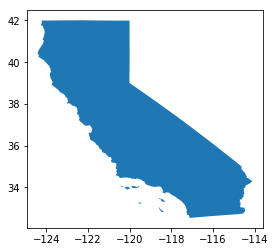

In [123]:
ca_state = ca_counties[["state", "geometry"]].dissolve(by ="state", aggfunc='first', as_index=False)


In [139]:
ca_state.geometry = ca_state.geometry.simplify(tolerance = 0.1)

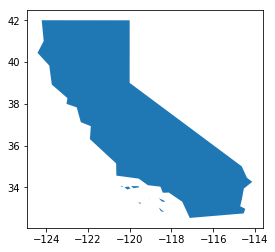

In [140]:
ca_state.plot()

In [74]:
ca_wrs.drop(columns = "centroid", inplace=True )

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [88]:
causes = pd.read_csv("Fire_Prediction/Causes.txt")
causes

Cause Code               Description
0            1                 Lightning
1            2             Equipment Use
2            3                   Smoking
3            4                  Campfire
4            5                    Debris
5            6                  Railroad
6            7                     Arson
7            8         Playing with Fire
8            9             Miscellaneous
9           10                   Vehicle
10          11                Power Line
11          12      Firefighter Training
12          13  Non-Firefighter Training
13          14      Unknown/Unidentified
14          15                 Structure
15          16                  Aircraft
16          17                  Volcanic
17          18   Escaped Prescribed Burn
18          19    Illegal Alien Campfire

In [92]:
causes_d = dict(zip(causes["Cause Code"], causes["Description"]))
causes_d


{1: 'Lightning',
 2: 'Equipment Use',
 3: 'Smoking',
 4: 'Campfire',
 5: 'Debris',
 6: 'Railroad',
 7: 'Arson',
 8: 'Playing with Fire',
 9: 'Miscellaneous',
 10: 'Vehicle',
 11: 'Power Line',
 12: 'Firefighter Training',
 13: 'Non-Firefighter Training',
 14: 'Unknown/Unidentified',
 15: 'Structure',
 16: 'Aircraft',
 17: 'Volcanic',
 18: 'Escaped Prescribed Burn',
 19: 'Illegal Alien Campfire'}

In [101]:
fire_peri = gpd.read_file("Fire_Prediction/Fire_Peri.shp")

fire_peri.tail()

OBJECTID YEAR_ STATE AGENCY UNIT_ID     FIRE_NAME   INC_NUM  \
20091   20711.0  2017    CA    USF     ENF         FORNI  00023406   
20092   20712.0  2017    CA    DOD     MCP  CRISTIANITOS  01702047   
20093   20713.0  2014  None    USF     KNF         RIVER  01706227   
20094   20714.0  2014  None    USF     KNF         ETHEL  00005977   
20095   20715.0  2016  None    USF     SHF          MILL  00000802   

                    ALARM_DATE                CONT_DATE  CAUSE  \
20091  2017/08/11 00:00:00.000  2017/08/14 00:00:00.000   14.0   
20092  2017/06/28 00:00:00.000  2017/06/30 00:00:00.000    9.0   
20093  2014/05/02 00:00:00.000  2014/05/12 00:00:00.000    9.0   
20094  2014/08/12 00:00:00.000  2014/09/15 00:00:00.000    1.0   
20095  2016/05/19 00:00:00.000  2016/05/20 00:00:00.000    9.0   

                                           COMMENTS  REPORT_AC   GIS_ACRES  \
20091                          maybe campfire start        7.5   12.267185   
20092                         started by RC bicycle        NaN  702.306641   
20093  perimeter for 2014, not previously submitted       17.0   16.001045   
20094  perimeter for 2014, not previously submitted       13.8   11.619938   
20095  perimeter for 2016, not previously submitted       56.0   57.677917   

       C_METHOD  OBJECTIVE FIRE_NUM    Shape_Leng    Shape_Area  \
20091       8.0        1.0     None    923.961025  4.964354e+04   
20092       5.0        1.0     None  14502.847837  2.842134e+06   
20093       1.0        1.0     None   1189.931592  6.475393e+04   
20094       6.0        1.0     None    868.597134  4.702422e+04   
20095       1.0        1.0     None   2526.086042  2.334143e+05   

                                                geometry  
20091  POLYGON ((-120.2075692544356 38.82391686875685...  
20092  (POLYGON ((-117.5689774386744 33.4394821472451...  
20093  POLYGON ((-123.0297752774592 41.78151886625032...  
20094  POLYGON ((-123.2145413517641 41.44424817757383...  
20095  POLYGON ((-122.3306829905509 41.43772946193435...

In [148]:
ca_map = folium.Map([37.166111, -119.449444], zoom_start = 6, detect_retina=True)
popup = folium.GeoJsonTooltip(fields = ["PATH", "ROW"], sticky= True)
poly = folium.GeoJson(ca_wrs, name = "PATH ROW", tooltip=popup)
fire_popup = folium.GeoJsonTooltip(fields = ["FIRE_NAME", "GIS_ACRES"], aliases=["Fire Name", "Fire Area"], sticky= True)



folium.GeoJson(
    fire_peri.iloc[:100],
    tooltip = fire_popup,
    style_function=lambda feature: {
        'fillColor': "#FF0000",
        'color' : "#000000",
        'weight' : 1,
        'fillOpacity' : 0.5
        }, 

    ).add_to(ca_map)
ca_map.add_child(poly)

folium.GeoJson(
    ca_state,
    style_function=lambda feature: {
        'fillColor': "#FF0000",
        'color' : "#000000",
        'weight' : 1,
        'fillOpacity' : 0.1
        }
    ).add_to(ca_map)

#f = folium.GeoJson(fire_peri.iloc[:20], name = "Fire")

for i, r in label_df[(label_df.Label == 1) & (label_df.CAUSE != 14)].iterrows():
    if i > 20: 
        break
    marker = folium.Marker([r.Y, r.X], popup=f"Fire due to {causes_d[r.CAUSE]}")
    ca_map.add_child(marker)

ca_map.save("map.html")
ca_map

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt


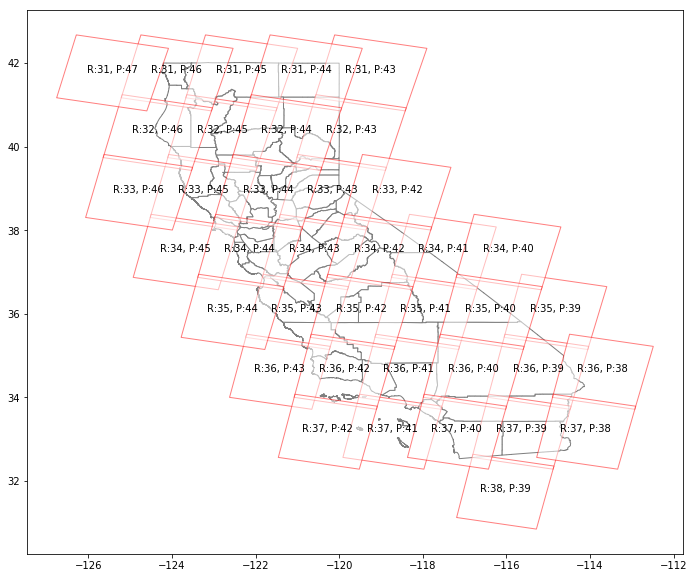

In [10]:
g, ax = plt.subplots(1, figsize=(15,10))

ca_counties.plot(ax = ax, color = 'white', edgecolor = 'k')
ca_wrs.plot(ax = ax, alpha=0.5, color = 'white', edgecolor = 'r')
for idx, row in ca_wrs.iterrows():
    geom = row['geometry'].centroid
    plt.annotate(s=f"R:{row['ROW']}, P:{row['PATH']}" , xy=(geom.x, geom.y), horizontalalignment='center')
                 
                 

In [11]:
set(ca_wrs.PATH), set(ca_wrs.ROW)


({38, 39, 40, 41, 42, 43, 44, 45, 46, 47}, {31, 32, 33, 34, 35, 36, 37, 38})

In [26]:
ca_wrs["centroid"] = ca_wrs.centroid

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:
ca_wrs.tail()


AREA  PERIMETER    PR_  PR_ID  RINGS_OK  RINGS_NOK  PATH  ROW MODE  \
23719  3.11508    7.14451  532.0  532.0         1          0    40   36    D   
23720  3.06446    7.07686  533.0  533.0         1          0    40   37    D   
25574  3.42826    7.56676  527.0  527.0         1          0    47   31    D   
27315  3.11508    7.14451  532.0  532.0         1          0    38   36    D   
27316  3.06446    7.07686  533.0  533.0         1          0    38   37    D   

       SEQUENCE   WRSPR      PR ACQDayL7 ACQDayL8  \
23719     49636  040036  040036       14        6   
23720     49637  040037  040037       14        6   
25574     53351  047031  047031       15        7   
27315     56828  038036  038036       16        8   
27316     56829  038037  038037       16        8   

                                                geometry  \
23719  POLYGON ((-117.9857331701011 34.00076123644914...   
23720  POLYGON ((-118.3643167003052 32.56420073281667...   
25574  POLYGON ((-126.7564854298747 41.16652511656823...   
27315  POLYGON ((-114.8957331701011 34.00076123644914...   
27316  POLYGON ((-115.2743167003052 32.56420073281667...   

                                           centroid  
23719  POINT (-116.7889093880367 34.61378200485937)  
23720  POINT (-117.1884481985111 33.18006495924431)  
25574  POINT (-125.4306281391167 41.76238678690655)  
27315  POINT (-113.6989093880368 34.61378200485937)  
27316  POINT (-114.0984481985111 33.18006495924431)

## Download all available landsat scenes from AWS S3 as CSV

In [20]:
s3_scenes = pd.read_csv('http://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz', \
                        compression='gzip', parse_dates=["acquisitionDate"])


In [21]:
s3_scenes.tail()


productId               entityId  \
1502660  LC08_L1TP_232082_20190406_20190422_01_T1  LC82320822019096LGN00   
1502661  LC08_L1TP_232085_20190406_20190422_01_T1  LC82320852019096LGN00   
1502662  LC08_L1TP_232089_20190406_20190422_01_T1  LC82320892019096LGN00   
1502663  LC08_L1TP_232090_20190406_20190422_01_T1  LC82320902019096LGN00   
1502664  LC08_L1TP_232094_20190406_20190422_01_T1  LC82320942019096LGN00   

                   acquisitionDate  cloudCover processingLevel  path  row  \
1502660 2019-04-06 14:26:36.707073        0.04            L1TP   232   82   
1502661 2019-04-06 14:27:48.558103        0.41            L1TP   232   85   
1502662 2019-04-06 14:29:24.380654       60.06            L1TP   232   89   
1502663 2019-04-06 14:29:48.339470       89.50            L1TP   232   90   
1502664 2019-04-06 14:31:24.187438       65.13            L1TP   232   94   

          min_lat   min_lon   max_lat   max_lon  \
1502660 -32.79864 -69.99221 -30.68505 -67.50914   
1502661 -37.10072 -71.26685 -34.97684 -68.65788   
1502662 -42.82896 -73.16721 -40.68029 -70.34582   
1502663 -44.30102 -73.69213 -42.12696 -70.63052   
1502664 -49.94721 -75.95616 -47.78851 -72.60773   

                                              download_url  
1502660  https://s3-us-west-2.amazonaws.com/landsat-pds...  
1502661  https://s3-us-west-2.amazonaws.com/landsat-pds...  
1502662  https://s3-us-west-2.amazonaws.com/landsat-pds...  
1502663  https://s3-us-west-2.amazonaws.com/landsat-pds...  
1502664  https://s3-us-west-2.amazonaws.com/landsat-pds...

In [22]:
from datetime import timedelta  
from shapely.geometry import Point
import numpy as np


In [23]:
from datetime import datetime  

s3_scenes = s3_scenes[
    (s3_scenes['acquisitionDate'] >= datetime(2015, 1, 1)) & 
    (s3_scenes['acquisitionDate'] < datetime(2018, 1, 1)) & 
    (s3_scenes['path'].isin (set(ca_wrs.PATH))) & 
    (s3_scenes['row'].isin( set(ca_wrs.ROW)))
]

## ^^ Need to only work with scenes in our study time period and study area
len(s3_scenes)

4986

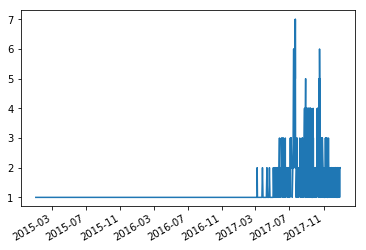

In [24]:
s3_scenes['acquisitionDate'].value_counts().plot()


In [25]:
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # radius of Earth in meters
    phi_1 = np.radians(lat1)
    phi_2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # output distance in km


## Identify satellite image corresponding to each fire & non-fire centroid

In [60]:
def return_scene(item):
    i, record = item
    #create a shapely point geometry using Fire Centroid's X and Y coordinate
    pt = Point(record["X"], record["Y"])
    #Identify paths and rows intersecting w/ the centroid
    wrs_intersection = ca_wrs[ca_wrs.intersects(pt)]
    
    paths, rows, centroids = (
                                wrs_intersection['PATH'].values, 
                                wrs_intersection['ROW'].values, 
                                wrs_intersection["centroid"]
                            )
    scenes = []
    # Iterate through paths and rows
    for path, row, centroid in zip(paths, rows, centroids):
        from_dt = record.ALARM_DATE + timedelta(days=-1)
        to_dt = record.ALARM_DATE + timedelta(days=-16)
        # Filter the Landsat Amazon S3 table for images matching path, row, cloudcover and processing state.
        path_row_scenes = s3_scenes[(s3_scenes.path == path) & (s3_scenes.row == row) & 
                           (~s3_scenes.productId.str.contains('_T2')) &
                           (~s3_scenes.productId.str.contains('_RT')) & 
                           (s3_scenes['acquisitionDate'] <= from_dt) & 
                           (s3_scenes['acquisitionDate'] >= to_dt)]
        path_row_scenes["days2Fire"] = (record.ALARM_DATE - 
                                        path_row_scenes['acquisitionDate']).dt.days
        path_row_scenes["dist"] = haversine(centroid.x, centroid.y,pt.x,pt.y)
        path_row_scenes["score"] = (path_row_scenes["days2Fire"] * 
                                    path_row_scenes["cloudCover"] * 
                                    np.log(path_row_scenes["dist"]))
        scenes.append(path_row_scenes)

    # If any scenes exists, select the one that have the minimum cloudCover.
    scenes = pd.concat(scenes)
    if i %100 == 0:
        print(f"{i * 100//len(label_df)}% complete...")    
    
    if len(scenes):
        scene = scenes.sort_values('score').iloc[0]
        # Add the selected scene to the bulk download list.
        scene = pd.concat([scene, record.T])
        return scene
    
    

In [64]:
r = list(label_df.iterrows())
print(len(r))
return_scene(r[0])

1878
0% complete...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

productId                   LC08_L1TP_041036_20160215_20170224_01_T1
entityId                                       LC80410362016046LGN01
acquisitionDate                           2016-02-15 18:28:15.686698
cloudCover                                                      0.57
processingLevel                                                 L1TP
path                                                              41
row                                                               36
min_lat                                                      33.5207
min_lon                                                     -119.603
max_lat                                                      35.6504
max_lon                                                     -117.034
download_url       https://s3-us-west-2.amazonaws.com/landsat-pds...
days2Fire                                                          9
dist                                                         79.0059
score                             

In [65]:
from multiprocessing import Pool

num_cores = 10

def parallelize_operation(lt, func):
    pool = Pool(num_cores)
    results = pd.concat(pool.map(func, lt), 1).T
    pool.close()
    pool.join()
    return results


#creating dataframe
bulk_frame = parallelize_operation(r, return_scene)
bulk_frame.tail().T



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0% complete...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

5% complete...
10% complete...
15% complete...
21% complete...
42% complete...
47% complete...
26% complete...
31% complete...
37% complete...
53% complete...
58% complete...
63% complete...
69% complete...
85% complete...
74% complete...
90% complete...
95% complete...
79% complete...


1815  \
productId                 LC08_L1TP_039036_20170526_20170615_01_T1   
entityId                                     LC80390362017146LGN00   
acquisitionDate                         2017-05-26 18:15:31.784534   
cloudCover                                                    0.25   
processingLevel                                               L1TP   
path                                                            39   
row                                                             36   
min_lat                                                    33.5349   
min_lon                                                   -116.462   
max_lat                                                    35.6665   
max_lon                                                   -114.007   
download_url     https://s3-us-west-2.amazonaws.com/landsat-pds...   
days2Fire                                                       13   
dist                                                       68.6911   
score                                                      13.7463   
X                                                         -114.517   
Y                                                          34.4626   
ALARM_DATE                                     2017-06-09 00:00:00   
CONT_DATE                                  2017/06/10 00:00:00.000   
CAUSE                                                            2   
Label                                                            0   

                                                              1816  \
productId                 LC08_L1TP_041036_20160606_20170223_01_T1   
entityId                                     LC80410362016158LGN01   
acquisitionDate                         2016-06-06 18:28:00.976809   
cloudCover                                                   19.48   
processingLevel                                               L1TP   
path                                                            41   
row                                                             36   
min_lat                                                    33.5208   
min_lon                                                     -119.6   
max_lat                                                    35.6532   
max_lon                                                   -117.028   
download_url     https://s3-us-west-2.amazonaws.com/landsat-pds...   
days2Fire                                                       15   
dist                                                       54.1159   
score                                                      1166.21   
X                                                         -118.593   
Y                                                          35.0514   
ALARM_DATE                                     2016-06-22 00:00:00   
CONT_DATE                                  2016/06/22 00:00:00.000   
CAUSE                                                           14   
Label                                                            0   

                                                              1817  \
productId                 LC08_L1TP_043034_20170623_20170630_01_T1   
entityId                                     LC80430342017174LGN00   
acquisitionDate                         2017-06-23 18:39:38.895162   
cloudCover                                                    1.39   
processingLevel                                               L1TP   
path                                                            43   
row                                                             34   
min_lat                                                    36.3928   
min_lon                                                   -121.861   
max_lat                                                    38.5339   
max_lon                                                   -119.323   
download_url     https://s3-us-west-2.amazonaws.com/landsat-pds...   
days2Fire                                                        3   


In [115]:
bulk_frame = bulk_frame.sample(frac=1).reset_index(drop=True)

bulk_frame.tail()


productId               entityId  \
1815  LC08_L1TP_045032_20170808_20170823_01_T1  LC80450322017220LGN00   
1816  LC08_L1TP_042034_20160731_20180201_01_T1  LC80420342016213LGN02   
1817  LC08_L1TP_044031_20150727_20170226_01_T1  LC80440312015208LGN01   
1818  LC08_L1TP_041036_20160505_20170223_01_T1  LC80410362016126LGN01   
1819  LC08_L1TP_040036_20170704_20170716_01_T1  LC80400362017185LGN00   

                 acquisitionDate cloudCover processingLevel path row  min_lat  \
1815  2017-08-08 18:51:28.556358       2.83            L1TP   45  32  39.2563   
1816  2016-07-31 18:33:44.113636       2.68            L1TP   42  34  36.3692   
1817  2015-07-27 18:44:29.595708       1.99            L1TP   44  31  40.6715   
1818  2016-05-05 18:27:56.417368      56.21            L1TP   41  36    33.52   
1819  2017-07-04 18:21:56.578806          0            L1TP   40  36  33.5405   

      min_lon  max_lat  ...   \
1815 -124.151  41.3856  ...    
1816 -120.378  38.5126  ...    
1817 -122.146  42.8227  ...    
1818  -119.64  35.6523  ...    
1819 -118.016  35.6581  ...    

                                           download_url days2Fire     dist  \
1815  https://s3-us-west-2.amazonaws.com/landsat-pds...         8  105.569   
1816  https://s3-us-west-2.amazonaws.com/landsat-pds...         4  36.3371   
1817  https://s3-us-west-2.amazonaws.com/landsat-pds...         2  62.2655   
1818  https://s3-us-west-2.amazonaws.com/landsat-pds...         7  108.212   
1819  https://s3-us-west-2.amazonaws.com/landsat-pds...         8  58.1555   

        score        X        Y           ALARM_DATE                CONT_DATE  \
1815  105.488 -121.725  40.8164  2017-08-17 00:00:00  2017/08/17 00:00:00.000   
1816  38.5152 -118.642  37.5292  2016-08-05 00:00:00  2016/08/10 00:00:00.000   
1817   16.443 -121.259  41.3228  2015-07-30 00:00:00  2015/08/07 00:00:00.000   
1818  1843.05 -117.362  35.1714  2016-05-13 00:00:00  2016/05/14 00:00:00.000   
1819        0 -116.679   35.129  2017-07-13 00:00:00  2017/07/13 00:00:00.000   

     CAUSE Label  
1815    10     0  
1816     2     1  
1817     1     0  
1818    14     0  
1819    14     0  

[5 rows x 21 columns]

In [6]:
bulk_frame.to_csv("Training_Set_Scenes.csv", index=False)

NameError: name 'bulk_frame' is not defined

In [2]:
bulk_frame = pd.read_csv("Training_Set_Scenes.csv")
bulk_frame.tail().T

1815  \
productId                 LC08_L1TP_045032_20170808_20170823_01_T1   
entityId                                     LC80450322017220LGN00   
acquisitionDate                         2017-08-08 18:51:28.556358   
cloudCover                                                    2.83   
processingLevel                                               L1TP   
path                                                            45   
row                                                             32   
min_lat                                                    39.2563   
min_lon                                                   -124.151   
max_lat                                                    41.3856   
max_lon                                                   -121.427   
download_url     https://s3-us-west-2.amazonaws.com/landsat-pds...   
days2Fire                                                        8   
dist                                                       105.569   
score                                                      105.488   
X                                                         -121.725   
Y                                                          40.8164   
ALARM_DATE                                     2017-08-17 00:00:00   
CONT_DATE                                  2017/08/17 00:00:00.000   
CAUSE                                                           10   
Label                                                            0   

                                                              1816  \
productId                 LC08_L1TP_042034_20160731_20180201_01_T1   
entityId                                     LC80420342016213LGN02   
acquisitionDate                         2016-07-31 18:33:44.113636   
cloudCover                                                    2.68   
processingLevel                                               L1TP   
path                                                            42   
row                                                             34   
min_lat                                                    36.3692   
min_lon                                                   -120.378   
max_lat                                                    38.5126   
max_lon                                                   -117.668   
download_url     https://s3-us-west-2.amazonaws.com/landsat-pds...   
days2Fire                                                        4   
dist                                                       36.3371   
score                                                      38.5152   
X                                                         -118.642   
Y                                                          37.5292   
ALARM_DATE                                     2016-08-05 00:00:00   
CONT_DATE                                  2016/08/10 00:00:00.000   
CAUSE                                                            2   
Label                                                            1   

                                                              1817  \
productId                 LC08_L1TP_044031_20150727_20170226_01_T1   
entityId                                     LC80440312015208LGN01   
acquisitionDate                         2015-07-27 18:44:29.595708   
cloudCover                                                    1.99   
processingLevel                                               L1TP   
path                                                            44   
row                                                             31   
min_lat                                                    40.6715   
min_lon                                                   -122.146   
max_lat                                                    42.8227   
max_lon                                                   -119.435   
download_url     https://s3-us-west-2.amazonaws.com/landsat-pds...   
days2Fire                                                        2   


In [3]:
bulk_frame.rename(columns={'productId': 'image_name', 'Label': 'tags'}, inplace=True)


In [165]:
bulk_frame[["image_name", "tags"]].to_csv("Trg_Data_Satimg_Class.csv", index = False)

## Creating Training Data

In [4]:
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Polygon
%matplotlib inline

In [7]:
bulk_frame = pd.read_csv("Training_Set_Scenes.csv")


In [5]:
record = bulk_frame.iloc[1]
record.download_url


'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/043/033/LC08_L1TP_043033_20160807_20170222_01_T1/index.html'

In [7]:
!pip install mercantile


You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import mercantile
from skimage import exposure
from rasterio.vrt import WarpedVRT
from rasterio.features import rasterize
from rasterio.transform import IDENTITY
from multiprocessing import Pool, cpu_count

In [6]:
num_cores = cpu_count()

In [14]:
"""
url = record['download_url'].replace("index.html", record.image_name + "_B{}.TIF")

lng, lat = record.X, record.Y
tile = mercantile.tile(lng, lat, 12)
merc_bounds = mercantile.xy_bounds(tile)
"""


In [110]:
red.crs


CRS.from_dict(init='epsg:32611')

In [109]:

red.window(*merc_bounds)


Window(col_off=-448939.3383950976, row_off=-7779.472800885123, width=326.131320683402, height=326.1313206834893)

In [7]:
# libs
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import rescale
import skimage.color as color

In [12]:
# functions 
def stretch(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands)
    for i in range(bands.shape[-1]):
        a = 0 
        b = 255 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[:,:,i] =t
    return out.astype(np.uint16)

def pansharpen(red, green, blue, nir, pan, method='browley', W=0.1, all_data=False):
    
    # get m_bands
    rgbn = np.empty((red.shape[0], red.shape[1], 4)) 
    rgbn[:,:,0] = red # red
    rgbn[:,:,1] = green # green
    rgbn[:,:,2] = blue # blue
    rgbn[:,:,3] = nir # NIR-1
    
    # scaled them
    rgbn_scaled = np.empty((red.shape[0]*2, red.shape[1]*2, 4))

    for i in range(4):
        img = rgbn[:,:,i]
        scaled = rescale(img, (2,2))
        rgbn_scaled[:,:,i] = scaled
    
    # check size and crop for pan band
    if pan.shape[0] < rgbn_scaled.shape[0]:
        rgbn_scaled = rgbn_scaled[:pan.shape[0],:, :]
    else:
        pan = pan[:rgbn_scaled.shape[0], :]
        
    if pan.shape[1] < rgbn_scaled.shape[1]:
        rgbn_scaled = rgbn_scaled[:,:pan.shape[1], :]
    else:
        pan = pan[:,:rgbn_scaled.shape[1]]

    R = rgbn_scaled[:,:,0]
    G = rgbn_scaled[:,:,1]
    B = rgbn_scaled[:,:,2]
    I = rgbn_scaled[:,:,3]

    image = None

    if method == 'simple_browley':
        all_in = R+G+B
        prod = np.multiply(all_in, pan)

        r = np.multiply(R, pan/all_in)[:, :, np.newaxis]
        g = np.multiply(G, pan/all_in)[:, :, np.newaxis]
        b = np.multiply(B, pan/all_in)[:, :, np.newaxis]

        image = np.concatenate([r,g,b], axis=2)
    
    if method == 'sample_mean':
        r = 0.5 * (R + pan)[:, :, np.newaxis]
        g = 0.5 * (G + pan)[:, :, np.newaxis]
        b = 0.5 * (B + pan)[:, :, np.newaxis]
        
        image = np.concatenate([r,g,b], axis=2)
        
    if method == 'esri':
        ADJ = pan-rgbn_scaled.mean(axis=2) 
        r = (R + ADJ)[:, :, np.newaxis]
        g = (G + ADJ)[:, :, np.newaxis]
        b = (B + ADJ)[:, :, np.newaxis]
        i = (I + ADJ)[:, :, np.newaxis]
        
        image = np.concatenate([r,g,b,i], axis=2)
    
    if method == 'browley':
        DNF = (pan - W*I)/(W*R + W*G + W*B)

        r = (R * DNF)[:, :, np.newaxis]
        g = (G * DNF)[:, :, np.newaxis]
        b = (B * DNF)[:, :, np.newaxis]
        i = (I * DNF)[:, :, np.newaxis]

        image = np.concatenate([r,g,b,i], axis=2)
    
    if method == 'hsv':
        hsv = color.rgb2hsv(rgbn_scaled[:,:,:3])
        hsv[:,:,2] = pan - I*W
        image = color.hsv2rgb(hsv)
        
    if all_data:
        return rgbn_scaled, image, I
    else:
        return image

In [9]:
#Get band download url template
record = bulk_frame.iloc[120]

url = record['download_url'].replace("index.html", record['image_name'] + "_B{}.TIF")
#Fire Lat Long
lng, lat = record.X, record.Y
#Get Web Mercator Tile (Google Maps Schema) at a given Zoom Level and find it's bounding box
tile = mercantile.tile(lng, lat, 12)
merc_bounds = mercantile.xy_bounds(tile)

with WarpedVRT(rasterio.open(url.format(5)), crs='epsg:3857') as nir_vrt: 
    with WarpedVRT(rasterio.open(url.format(4)) , crs='epsg:3857') as r_vrt:
        with WarpedVRT(rasterio.open(url.format(3)), crs='epsg:3857') as g_vrt:
            with WarpedVRT(rasterio.open(url.format(2)) , crs='epsg:3857') as b_vrt:
                with WarpedVRT(rasterio.open(url.format(8)), crs='epsg:3857') as pan_vrt: 
                    with WarpedVRT(rasterio.open(url.format(10)), crs='epsg:3857') as t_vrt: 
                        with WarpedVRT(rasterio.open(url.format(11)), crs='epsg:3857') as t2_vrt:
                            with WarpedVRT(rasterio.open(url.format(6)), crs='epsg:3857') as s1_vrt:
                                with WarpedVRT(rasterio.open(url.format(7)), crs='epsg:3857') as s2_vrt: 


                                    window = r_vrt.window(*merc_bounds)
                                    pan_window = pan_vrt.window(*merc_bounds)
                                    thermal_window = t_vrt.window(*merc_bounds)


                                    x_pixel_width = (merc_bounds.right - merc_bounds.left) / window.width
                                    y_pixel_width = (merc_bounds.top - merc_bounds.bottom) / window.height

                                    #arr_transform = r_vrt.window_transform(window)

                                    nir_arr = nir_vrt.read(window=window)[0]
                                    r_arr = r_vrt.read(window=window)[0]
                                    g_arr = g_vrt.read(window=window)[0]
                                    b_arr = b_vrt.read(window=window)[0]
                                    s1_arr = s1_vrt.read(window=window)[0]
                                    s2_arr = s2_vrt.read(window=window)[0]

                                    pan_arr = pan_vrt.read(window = pan_window)[0]
                                    thermal_arr = t_vrt.read(window = thermal_window)[0]
                                    thermal2_arr = t2_vrt.read(window = thermal_window)[0]

                    

                    

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text(0.5,1,'NIR')

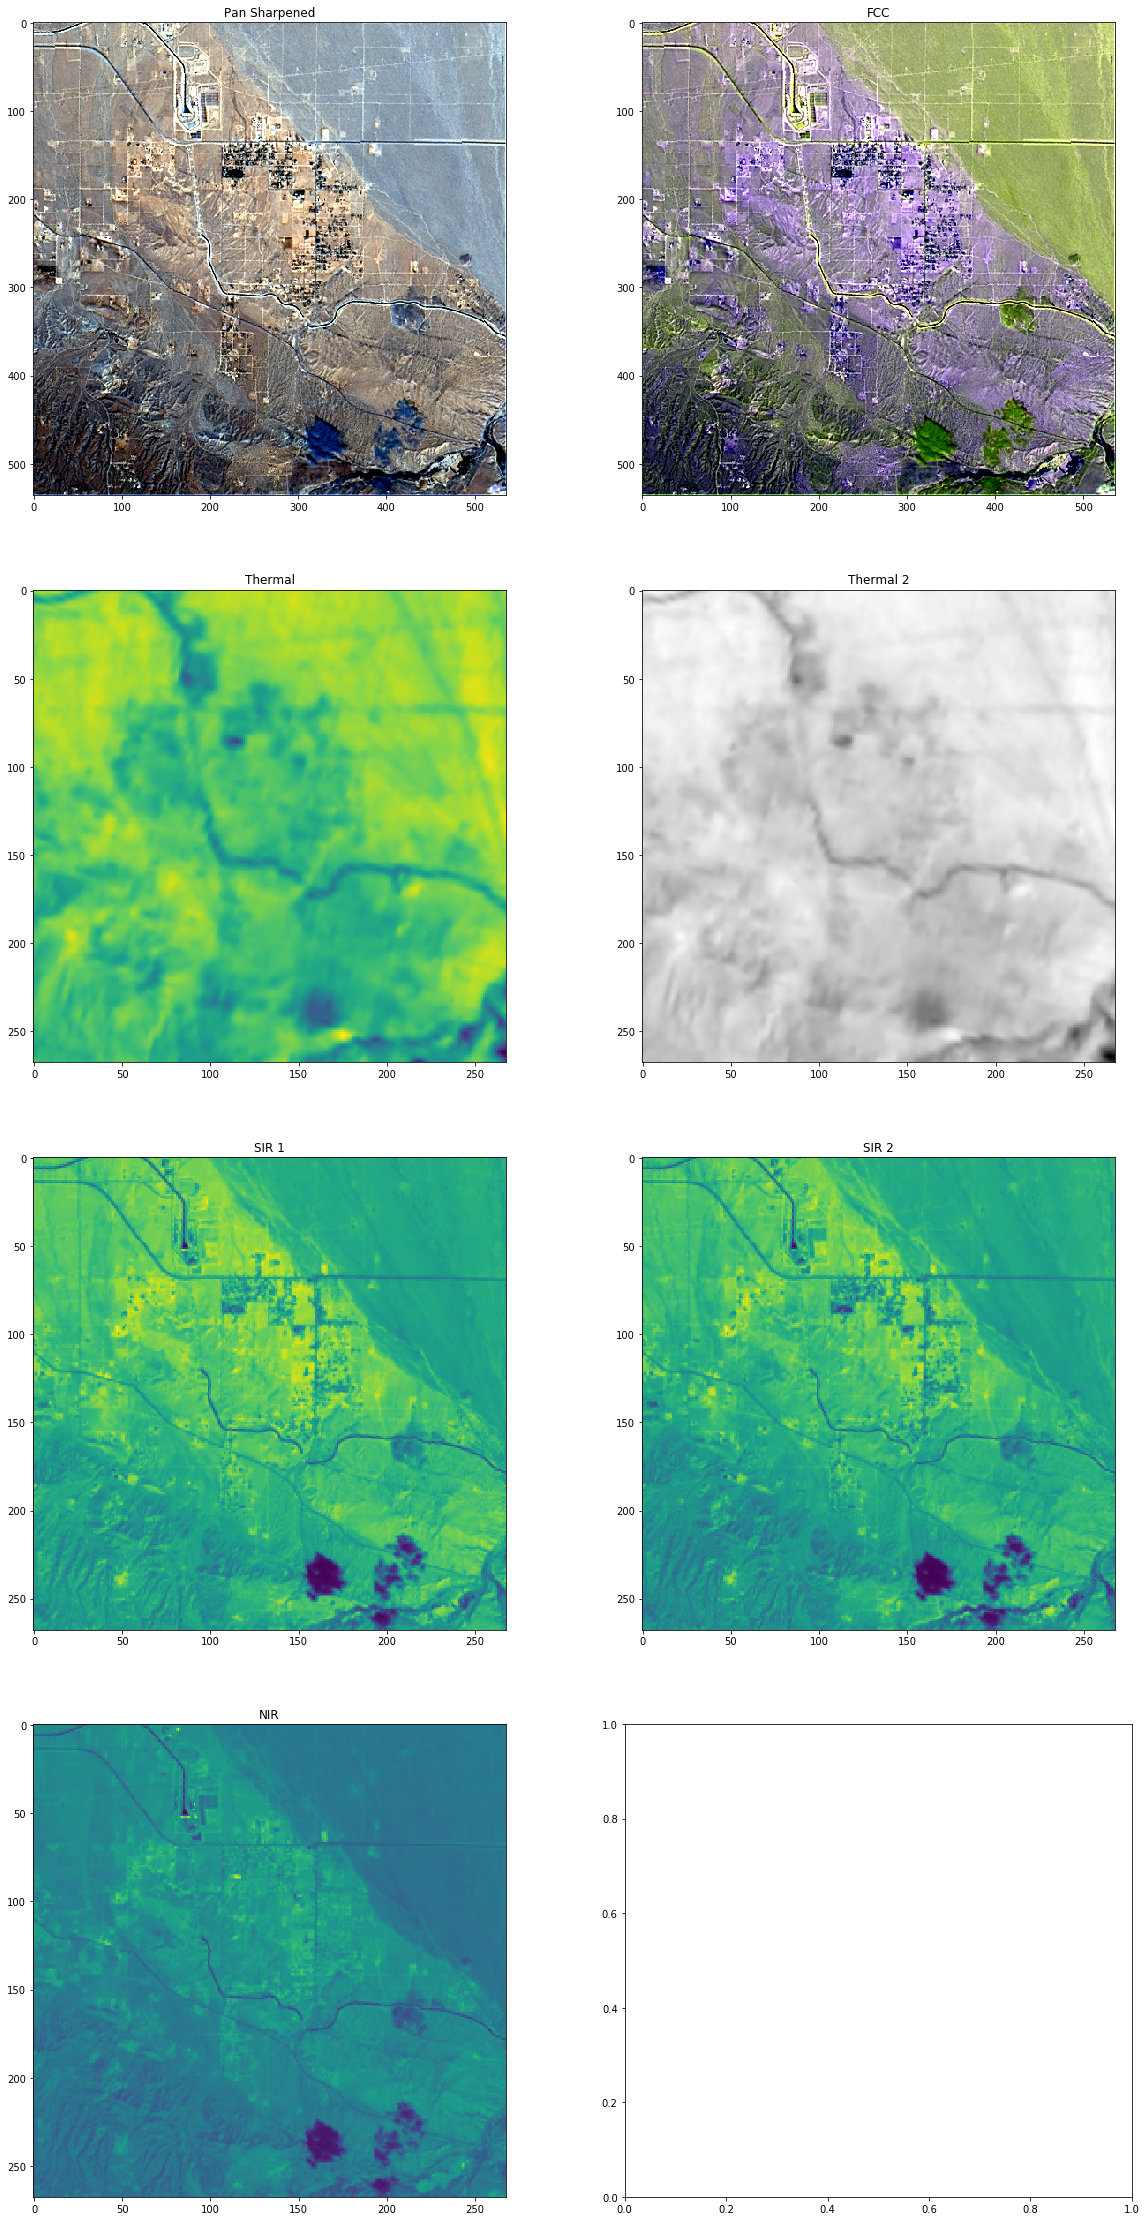

In [16]:
sharpened_browley6 = pansharpen(r_arr, g_arr, b_arr, nir_arr, pan_arr, W=0.3,)

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20, 40))
ax = axes.ravel()

ax[0].imshow(stretch(sharpened_browley6[:,:,:3], 2, 98))
ax[0].set_title('Pan Sharpened')

ax[1].imshow(stretch(sharpened_browley6[:,:,1:4], 2, 98))
ax[1].set_title('FCC')    

ax[2].imshow(thermal_arr)
ax[2].set_title('Thermal')

ax[3].imshow( thermal2_arr, cmap = "gray")
ax[3].set_title('Thermal 2')

ax[4].imshow(s1_arr)
ax[4].set_title('SIR 1')

ax[5].imshow(s2_arr)
ax[5].set_title('SIR 2')

ax[6].imshow(nir_arr)
ax[6].set_title('NIR')


In [19]:
import time
entity_dir = "Crimson_Red_Sky/"

rgb_image_dir = f"{entity_dir}/rgb_images"
fcc_image_dir = f"{entity_dir}/fcc_images"
tir1_image_dir = f"{entity_dir}/tir1_images"
tir2_image_dir = f"{entity_dir}/tir2_images"
sir1_image_dir = f"{entity_dir}/sir1_images"
sir2_image_dir = f"{entity_dir}/sir2_images"
nir_image_dir = f"{entity_dir}/nir_images"
label_dir = f"{entity_dir}/labels"

all_dirs = [entity_dir, rgb_image_dir, fcc_image_dir, tir1_image_dir, \
            tir2_image_dir, sir1_image_dir, sir2_image_dir, nir_image_dir, label_dir]

for dirc in all_dirs: 
    os.makedirs(dirc, exist_ok=True)


start = time.time()
l = len(bulk_frame)

def norm(arr):
        min_arr, max_arr = arr.min(), arr.max()
        return ((arr - min_arr) * 255.0 / (max_arr - min_arr)).astype('uint16')
    
def save_image(item):
    row_id, record = item
    #Get band download url template
    url = record['download_url'].replace("index.html", record['image_name'] + "_B{}.TIF")
    #Fire Lat Long
    lng, lat = record.X, record.Y
    #Get Web Mercator Tile (Google Maps Schema) at a given Zoom Level and find it's bounding box
    tile = mercantile.tile(lng, lat, 12)
    merc_bounds = mercantile.xy_bounds(tile)
    with WarpedVRT(rasterio.open(url.format(5)), crs='epsg:3857') as nir_vrt: 
        with WarpedVRT(rasterio.open(url.format(4)) , crs='epsg:3857') as r_vrt:
            with WarpedVRT(rasterio.open(url.format(3)), crs='epsg:3857') as g_vrt:
                with WarpedVRT(rasterio.open(url.format(2)) , crs='epsg:3857') as b_vrt:
                    with WarpedVRT(rasterio.open(url.format(8)), crs='epsg:3857') as pan_vrt: 
                        with WarpedVRT(rasterio.open(url.format(10)), crs='epsg:3857') as t_vrt: 
                            with WarpedVRT(rasterio.open(url.format(11)), crs='epsg:3857') as t2_vrt:
                                with WarpedVRT(rasterio.open(url.format(6)), crs='epsg:3857') as s1_vrt:
                                    with WarpedVRT(rasterio.open(url.format(7)), crs='epsg:3857') as s2_vrt: 


                                        window = r_vrt.window(*merc_bounds)
                                        pan_window = pan_vrt.window(*merc_bounds)
                                        thermal_window = t_vrt.window(*merc_bounds)


                                        x_pixel_width = (merc_bounds.right - merc_bounds.left) / window.width
                                        y_pixel_width = (merc_bounds.top - merc_bounds.bottom) / window.height

                                        #arr_transform = r_vrt.window_transform(window)

                                        nir_arr = nir_vrt.read(window=window)[0]
                                        r_arr = r_vrt.read(window=window)[0]
                                        g_arr = g_vrt.read(window=window)[0]
                                        b_arr = b_vrt.read(window=window)[0]
                                        s1_arr = s1_vrt.read(window=window)[0]
                                        s2_arr = s2_vrt.read(window=window)[0]

                                        pan_arr = pan_vrt.read(window = pan_window)[0]
                                        thermal_arr = t_vrt.read(window = thermal_window)[0]
                                        thermal2_arr = t2_vrt.read(window = thermal_window)[0]

                                        sharpened_browley6 = pansharpen(r_arr, g_arr, b_arr, nir_arr, pan_arr, W=0.3)


                                        plt.imsave(f"{rgb_image_dir}/{record.image_name}.png", stretch(sharpened_browley6[:,:,:3]))
                                        plt.imsave(f"{fcc_image_dir}/{record.image_name}.png", stretch(sharpened_browley6[:,:,1:4]))
                                        plt.imsave(f"{tir1_image_dir}/{record.image_name}.png", thermal_arr)
                                        plt.imsave(f"{tir2_image_dir}/{record.image_name}.png", thermal2_arr)
                                        plt.imsave(f"{sir1_image_dir}/{record.image_name}.png", s1_arr)
                                        plt.imsave(f"{sir2_image_dir}/{record.image_name}.png", s2_arr)
                                        plt.imsave(f"{nir_image_dir}/{record.image_name}.png", nir_arr)

                                        if row_id > 0 and row_id % 100 == 0 :
                                            print(f"{row_id * 100//l}% complete... {(time.time() - start) // 60} mins {(time.time() - start) % 60} s elapsed")



def parallelize_operation(lt, func):
    pool = Pool(num_cores)
    pool.map(func, lt)
    pool.close()
    pool.join()



In [20]:
parallelize_operation(list(bulk_frame.iterrows()), save_image)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant'

21% complete... 4.0 mins 51.70975685119629 s elapsed


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:77: RuntimeWarning: divide by zero encountered in true_divide
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:77: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:79: RuntimeWarning: invalid value encountered in multiply
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:80: RuntimeWarning: invalid value encountered in multiply
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in multiply
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:82: RuntimeWarning: invalid value encountered in multiply
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: In

16% complete... 5.0 mins 53.722755432128906 s elapsed
10% complete... 6.0 mins 51.585814476013184 s elapsed
5% complete... 8.0 mins 19.208553075790405 s elapsed
43% complete... 9.0 mins 34.163217544555664 s elapsed
38% complete... 10.0 mins 18.693626880645752 s elapsed
32% complete... 11.0 mins 0.24888896942138672 s elapsed
27% complete... 11.0 mins 40.33765244483948 s elapsed
49% complete... 15.0 mins 39.34635853767395 s elapsed
54% complete... 17.0 mins 45.957043409347534 s elapsed
71% complete... 18.0 mins 37.8514187335968 s elapsed
65% complete... 19.0 mins 19.910971641540527 s elapsed
60% complete... 19.0 mins 23.520219802856445 s elapsed
76% complete... 20.0 mins 59.45395493507385 s elapsed
87% complete... 22.0 mins 27.397573709487915 s elapsed
82% complete... 22.0 mins 43.115081787109375 s elapsed
98% complete... 27.0 mins 20.27077317237854 s elapsed
93% complete... 27.0 mins 39.67985510826111 s elapsed


RasterioIOError: HTTP response code: 404

In [208]:
for row_id, record in bulk_frame.iterrows():
#record = bulk_frame.iloc[5]

    lng, lat = record.X, record.Y
    tile = mercantile.tile(lng, lat, 12)
    merc_bounds = mercantile.xy_bounds(tile)
    project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), # source coordinate system
    pyproj.Proj(init='epsg:3857')) # destination coordinate system

    g2 = transform(project, Polygon(eval(record.coords)))  # apply projection
    x, y = g2.exterior.xy
    x = np.clip(
        np.divide(
            np.subtract(x, merc_bounds.left)
            , x_pixel_width
        )
        , 0
        , window.width
    )

    y = np.clip(
        np.divide(
            np.subtract(merc_bounds.top, y)
            , y_pixel_width
        )
        , 0
        , window.height
    )

    geometry = {'type':'Polygon','coordinates':[list(zip(x,y))]}

    rows,cols = int(window.height), int(window.width)
    result = rasterize([geometry], out_shape=(rows, cols), default_value = 1)

    with rasterio.open(f"{label_dir}/{record.productId}_label.png",'w', \
                       driver='PNG',width=cols, height=rows, \
                       count=1, dtype=np.uint8, nodata=0, \
                      ) as out:
        out.write_band(1, result.astype(np.uint8))
print('Done')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/rasterio/__init__.py:225: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  **kwargs)


Done


In [ ]:
# Import requests and beautiful soup
import requests
from rasterio import features
import copy
import base64
try:
    import io
except ImportError:
    import io as io

    


# For each row

entity_dir = "Crimson_Red_Sky/Fire"
os.makedirs(entity_dir, exist_ok=True)
os.makedirs(f"{entity_dir}/json", exist_ok=True)


for i, record in bulk_frame.iterrows():
    

    print('EntityId:', record.productId)
    
    url = record['download_url'].replace("index.html", record['productId'] + "_B{}.TIF")
    with rasterio.open(url.format(4)) as band4:
        with rasterio.open(url.format(3)) as band3:
            with rasterio.open(url.format(2)) as band2:
                    r = band4.read(1)
                    g = band3.read(1)
                    b = band2.read(1)
        
        # Get Reference system of Landsat image from rasterio
    utm = pyproj.Proj(band4.crs) 
    lonlat = pyproj.Proj(init='epsg:4326')
    lon,lat = record["X"], record["Y"]

    #Project Fire centroid lat lon values into projected coordinates as east, north (UTM - in m)
    east,north = pyproj.transform(lonlat, utm, lon, lat)

    #get pixel values at the centroid corrsponding to projected coordinates
    row, col = band4.index(east, north)

    #Project Fire Perimeter coordinates into UTM coorindates (m)
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'), # source coordinate system
        pyproj.Proj(init=band4.crs.data["init"])) # destination coordinate system

    g2 = transform(project, Polygon(eval(record.coords)))  # apply projection

    #Get pixel coordinates of fire perimeter

    subset_r = r[row - 250 : row + 250 , col - 250 : col + 250]
    subset_g = g[row - 250 : row + 250 , col - 250 : col + 250]
    subset_b = b[row - 250 : row + 250 , col - 250 : col + 250]
    
    
    with rasterio.open(f"{entity_dir}/{record.productId}.png", 'w',  driver='PNG',
            count=3,
            dtype=rasterio.uint16, width=500,
            height=500) as out:
        for k, arr in [(1, subset_r), (2, subset_g), (3, subset_b)]:
            out.write_band(k, arr)

    with open(f"{entity_dir}/{record.productId}.png", "rb") as image:
        encoded_string = base64.b64encode(image.read())
        
    if i <= 200 :
        label = "Fire"
    elif i <= 400:
        
        entity_dir = "Crimson_Red_Sky/Non Fire"
        os.makedirs(entity_dir, exist_ok=True)
        os.makedirs(f"{entity_dir}/json", exist_ok=True)
        label = "Non Fire"
    if i > 250:
        entity_dir = "Crimson_Red_Sky/Test"
        os.makedirs(entity_dir, exist_ok=True)

        continue

    poly = [band4.index(coord[0] , coord[1]) for coord in zip(*g2.exterior.xy)]
    
    opti_poly = []
    for coord in poly:
        x = coord[0] - row + 250
        y = coord[1] - col + 250

        if x > 500: 
            x = 500
        if x < 0:
            x = 0
        if y > 500: 
            y = 500
        if y < 0:
            y = 0
        opti_poly.append((x,y))
  
    

    e = copy.deepcopy(d)
    

    e["shapes"][0]['label'] = label
    e["shapes"][0]['points'] = np.take(opti_poly, np.sort(np.random.choice(range(len(opti_poly)), 15, )), axis = 0).tolist()

    e['imageData'] = encoded_string.decode('ascii')
    e['imageWidth'] = 500
    e['imageHeight'] = 500
    e['imagePath'] = f"{entity_dir}/{record.productId}.png"

    json.dump(e, open(f"{entity_dir}/json/{record.productId}.json", "w"))        
        
print('Done')

EntityId: LC08_L1TP_045032_20151006_20170225_01_T1


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/rasterio/__init__.py:225: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  **kwargs)


EntityId: LC08_L1TP_045032_20151107_20170225_01_T1
EntityId: LC08_L1TP_045032_20151107_20170225_01_T1
EntityId: LC08_L1TP_045032_20151107_20170225_01_T1
EntityId: LC08_L1TP_045032_20151107_20170225_01_T1
EntityId: LC08_L1TP_045032_20150803_20170226_01_T1
EntityId: LC08_L1TP_046032_20150810_20170226_01_T1
EntityId: LC08_L1TP_045032_20150819_20180131_01_T1
EntityId: LC08_L1TP_046032_20150810_20170226_01_T1
EntityId: LC08_L1TP_045032_20150819_20180131_01_T1
EntityId: LC08_L1TP_046031_20150810_20170226_01_T1
EntityId: LC08_L1TP_046032_20150810_20170226_01_T1
EntityId: LC08_L1TP_045032_20150819_20180131_01_T1
EntityId: LC08_L1TP_046031_20150810_20170226_01_T1
EntityId: LC08_L1TP_046032_20150810_20170226_01_T1
EntityId: LC08_L1TP_045032_20150819_20180131_01_T1
EntityId: LC08_L1TP_046031_20150810_20170226_01_T1
EntityId: LC08_L1TP_046032_20150810_20170226_01_T1
EntityId: LC08_L1TP_045032_20151107_20170225_01_T1
EntityId: LC08_L1TP_045032_20151022_20170225_01_T1
EntityId: LC08_L1TP_046032_2015

EntityId: LC08_L1TP_043035_20160604_20170223_01_T1
EntityId: LC08_L1TP_043035_20160503_20180201_01_T1
EntityId: LC08_L1TP_042035_20160512_20170223_01_T1
EntityId: LC08_L1TP_043035_20160706_20170221_01_T1
EntityId: LC08_L1TP_043035_20160519_20170223_01_T1
EntityId: LC08_L1TP_042035_20160512_20170223_01_T1
EntityId: LC08_L1TP_042035_20160528_20170223_01_T1
EntityId: LC08_L1TP_042036_20160528_20170223_01_T1
EntityId: LC08_L1TP_043035_20160722_20170221_01_T1
EntityId: LC08_L1TP_043035_20160706_20170221_01_T1
EntityId: LC08_L1TP_040037_20160615_20170220_01_T1
EntityId: LC08_L1TP_041037_20160708_20170222_01_T1
EntityId: LC08_L1TP_040037_20160701_20170222_01_T1
EntityId: LC08_L1TP_041037_20160622_20170222_01_T1
EntityId: LC08_L1TP_041037_20160724_20170222_01_T1
EntityId: LC08_L1TP_040037_20160717_20170222_01_T1
EntityId: LC08_L1TP_041037_20160910_20170222_01_T1
EntityId: LC08_L1TP_040037_20160919_20170222_01_T1
EntityId: LC08_L1TP_041037_20160926_20170220_01_T1
EntityId: LC08_L1TP_040037_2016

EntityId: LC08_L1TP_041035_20161129_20170219_01_T1
EntityId: LC08_L1TP_042035_20161206_20170219_01_T1
EntityId: LC08_L1TP_041035_20161028_20170219_01_T1
EntityId: LC08_L1TP_042035_20161019_20170219_01_T1
EntityId: LC08_L1TP_042034_20160731_20180201_01_T1
EntityId: LC08_L1TP_041035_20161129_20170219_01_T1
EntityId: LC08_L1TP_042035_20161206_20170219_01_T1
EntityId: LC08_L1TP_043034_20161026_20170219_01_T1
EntityId: LC08_L1TP_042034_20161019_20170219_01_T1
EntityId: LC08_L1TP_043034_20160908_20170222_01_T1
EntityId: LC08_L1TP_042034_20160901_20170222_01_T1
EntityId: LC08_L1TP_043033_20160823_20170223_01_T1
EntityId: LC08_L1TP_043033_20160417_20170223_01_T1
EntityId: LC08_L1TP_044032_20160408_20170223_01_T1
EntityId: LC08_L1TP_043033_20160924_20170222_01_T1
EntityId: LC08_L1TP_044033_20160915_20170222_01_T1
EntityId: LC08_L1TP_043033_20161026_20170219_01_T1
EntityId: LC08_L1TP_041036_20160606_20170223_01_T1
EntityId: LC08_L1TP_041036_20160708_20170222_01_T1
EntityId: LC08_L1TP_040036_2016

EntityId: LC08_L1TP_045031_20171011_20171024_01_T1
EntityId: LC08_L1TP_044032_20171004_20171014_01_T1
EntityId: LC08_L1TP_043034_20170927_20171013_01_T1
EntityId: LC08_L1TP_044034_20171004_20171014_01_T1
EntityId: LC08_L1TP_043034_20170911_20170927_01_T1
EntityId: LC08_L1TP_044034_20170918_20170929_01_T1
EntityId: LC08_L1TP_043034_20170725_20170810_01_T1
EntityId: LC08_L1TP_044034_20170716_20170727_01_T1
EntityId: LC08_L1TP_044034_20170716_20170727_01_T1
EntityId: LC08_L1TP_042036_20171006_20171023_01_T1
EntityId: LC08_L1TP_042036_20170819_20170826_01_T1
EntityId: LC08_L1TP_042036_20170702_20170715_01_T1
EntityId: LC08_L1TP_042036_20170702_20170715_01_T1
EntityId: LC08_L1TP_043036_20171013_20171024_01_T1
EntityId: LC08_L1TP_042036_20171006_20171023_01_T1
EntityId: LC08_L1TP_042036_20171209_20171223_01_T1
EntityId: LC08_L1TP_042036_20170803_20170812_01_T1
EntityId: LC08_L1TP_042036_20170819_20170826_01_T1
EntityId: LC08_L1TP_042036_20171209_20171223_01_T1
EntityId: LC08_L1TP_042036_2017

EntityId: LC08_L1TP_041036_20170711_20170726_01_T1
EntityId: LC08_L1TP_041036_20170727_20170810_01_T1
EntityId: LC08_L1TP_041036_20170727_20170810_01_T1
EntityId: LC08_L1TP_040036_20170805_20170812_01_T1
EntityId: LC08_L1TP_042036_20170803_20170812_01_T1
EntityId: LC08_L1TP_041036_20170828_20170914_01_T1
EntityId: LC08_L1TP_041036_20171218_20171224_01_T1
EntityId: LC08_L1TP_041036_20171218_20171224_01_T1
EntityId: LC08_L1TP_041035_20170524_20170614_01_T1
EntityId: LC08_L1TP_041036_20170524_20170614_01_T1
EntityId: LC08_L1TP_042035_20170531_20170615_01_T1
EntityId: LC08_L1TP_041035_20170524_20170614_01_T1
EntityId: LC08_L1TP_041035_20170711_20170726_01_T1
EntityId: LC08_L1TP_042035_20170718_20170728_01_T1
EntityId: LC08_L1TP_042036_20170718_20170728_01_T1
EntityId: LC08_L1TP_041036_20171031_20171109_01_T1
EntityId: LC08_L1TP_041036_20170828_20170914_01_T1
EntityId: LC08_L1TP_042036_20170904_20170916_01_T1
EntityId: LC08_L1TP_041035_20170929_20171013_01_T1
EntityId: LC08_L1TP_041035_2017

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/rasterio/__init__.py:225: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  **kwargs)


In [ ]:
geometry = {'type':'Polygon','coordinates':}
image = features.rasterize(
            ((g, 255) for g, v in shapes),
            out_shape=src.shape,
            transform=src.transform)